In [17]:
using LinearAlgebra, Distributions, Random, StatsBase, Plots, StatsPlots, DataFrames

function diagonal_analysis(mat::SymTridiagonal)
	Ωv = eigvals(mat)
	return Ωv
end

function ω_statistic(ω0, Δ, N::Int, t::Real)
	ωv = ω0 .+ rand(Normal(0, Δ), N)
	ham = SymTridiagonal(ωv, fill(t, N-1))
	Ωv = diagonal_analysis(ham)
	return ωv, Ωv
end

# plot a histogram of ω and a histogram of Ωv
function plot_histograms(ωv, Ωv)
	# plot histogram of ωv
	ωv_hist = fit(Histogram, ωv, nbins=50)
	p1 = plot(ωv_hist, label="ωv", xlabel="ω", ylabel="counts", legend=:topleft)
	Ωv_hist = fit(Histogram, Ωv, nbins=50)
	p2 = plot(Ωv_hist, label="Ωv", xlabel="Ω", ylabel="counts", legend=:topleft)
	return plot(p1, p2, layout=(2, 1), link=:x)
end

function plot_statistic(ω0, Δ, N::Int, t::Real)
	ωv, Ωv = ω_statistic(ω0, Δ, N, t)
	p = plot_histograms(ωv, Ωv)
	# plot!(p, title="ω0=$ω0, Δ=$Δ, N=$N, t=$t")
	title!(p, "ω0 = $ω0, Δ = $Δ, N = $N, t = $t")
	return p
end;

function count_states(N::Int, k::Int)::Int
	res = 1
	for n in N:N+k-1
		res *= n
	end
	return res / factorial(k)
end;

struct Ham
	ωv::Vector{Float64}
	t::Float64
	K::Float64
end

function ΔE(H::Ham, v::Vector)
	return sum(v ⋅ (v.-1) * H.K .+ v ⋅ H.K)
end

function E(H::Ham, v::Vector)
	N = length(v)
	hmat1 = SymTridiagonal(H.ωv, fill(H.t, N-1))
	e = v' * hmat1 * v
	# perturbation
	e += v ⋅ (v.-1) * H.K
	return e
end;

function spacingstats(hmat::SymTridiagonal, K::Float64, ws::Real, we::Real)
	Ω2 = []
	ΔΩ2 = []
	idx = 1
	T = eigen(hmat)
	Vdag = T.vectors';
	for i = 1:length(T.values), j = i:length(T.values)
		if ws <= T.values[i]-K <= we && ws <= T.values[j]-K <= we
			push!(Ω2, T.values[i] + T.values[j])
			push!(ΔΩ2, 4K * sum(abs2.(Vdag[i] .* Vdag[j])))
		end
		idx += 1
	end
	sort!(Ω2)
	Ω2pert = sort(Ω2 .+ ΔΩ2)
	return Ω2, Ω2pert
end


spacingstats (generic function with 1 method)

# Statistics 1

$$H = \sum_{j=1}^{N} a_j^\dagger a_j \omega_j + t \sum_{j=1}^{N-1} \left(a_j^\dagger a_{j+1} + a_j a_{j+1}^\dagger \right)$$

## time evolution

$$ \frac{d}{dt} a_j = \frac{i}{\hbar}[H, a_j] $$
using relations $[a_j, a_j^\dagger] = 1$ , $[a_j, a_k^\dagger] = 0$ $[a_j, a_k] = 0$ for  $j\neq k$:
$$[a_j, a_j^\dagger a_j \omega_j] = [a_j, a_j^\dagger] a_j \omega_j = a_j \omega_j$$
$$[a_j, a_j^\dagger a_{j+1} t] = [a_j, a_j^\dagger] a_{j+1} t = a_{j+1} t$$
$$ \frac{d}{dt} a_j = \frac{i}{\hbar}[H, a_j] = -\frac{i}{\hbar} \left[ \omega_j a_j + t a_{j+1} \right] $$

## normal modes

$$ H = \sum_{j=1}^N \Omega_j b_j^\dagger b_j $$

## Anderson transition

In [51]:
N = 20000
ω0 = 1
Δ = 0.001
trange = range(start=0.005, stop=0.1, length=3) # [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
Ωv = Array{Float64}(undef, length(trange), N÷2)
δΩ = Array{Float64}(undef, length(trange), N÷2-1)
for (i, t) in enumerate(trange)
	ωv = ω0 .+ rand(Normal(0, Δ), N)
	ham = SymTridiagonal(ωv, fill(t, N-1))
	Ωv[i, :] = eigvals(ham)[N÷4: N÷4 + N÷2-1]
	δΩ[i, :] = (Ωv[i, 2:end] - Ωv[i, 1:end-1])
end

In [46]:
# CUDA version
N = 20000
ω0 = 100.f0
Δ = 0.001f0
trange = Array{Float32}([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Ωv = CuArray{Float32}(undef, length(trange), N)
δΩ = CuArray{Float32}(undef, length(trange), N-1)
for (i, t) in enumerate(trange)
	CUDA.@sync ωv = ω0 .+ CUDA.randn(Float32, N).*Δ
	ham = SymTridiagonal(ωv, CUDA.fill(t, N-1))
	#Ωv[i, :] 
	# BLOBO = eigvals(ham)
	#δΩ[i, :] 
	# BLIBO = (Ωv[i, 2:end] - Ωv[i, 1:end-1])
    # test
end

UndefVarError: UndefVarError: CuArray not defined

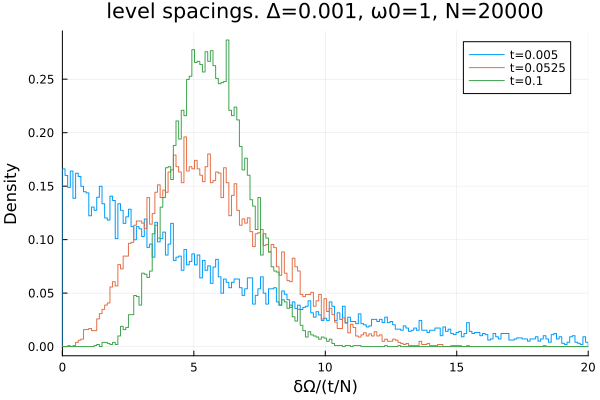

In [52]:
pall = plot();
stephist!(pall, transpose(δΩ./trange.*N),
		bins=range(start=0, stop=20, length=200),
		normalize=true, label=string.("t=", transpose(trange)),
		xlabel="δΩ/(t/N)", ylabel="Density", legend=:topright);
xlims!(pall, 0, 20);
plot!(pall, title="level spacings. Δ=$Δ, ω0=$ω0, N=$N");
# savefig(pall, "transition_detail.pdf")
# savefig(pall, "transition_detail.png")

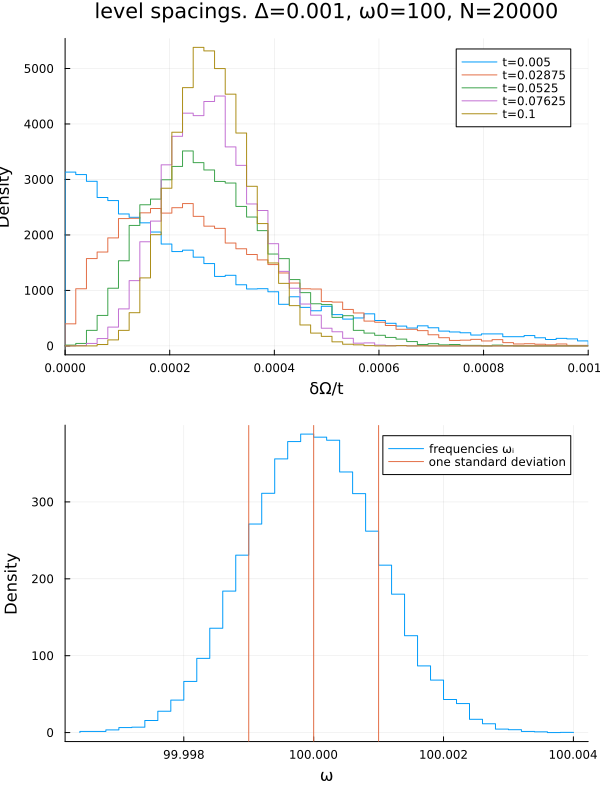

In [31]:
plot(pall, Ωplot, layout=(2, 1), size=(600, 800))


In [19]:
selection = [1,2,3];
psmall = plot();

stephist!(psmall, transpose(trange[selection]), transpose(δΩ[selection, :]),
			bins=range(start=0, stop=1.5e-6, length=100), normalize=true,
			label=string.("t=", transpose(trange[selection])),
			xlabel="δΩ", ylabel="Density", legend=:topright);
xlims!(psmall, 0, 1.5e-6);
plot!(psmall, title="level spacings for t<Δ");

In [20]:
selection = [4, 5, 6];
pbig = plot();

stephist!(pbig, transpose(trange[selection]), transpose(δΩ[selection, :]),
			bins=range(start=0, stop=3e-4, length=100), normalize=true,
			label=string.("t=", transpose(trange[selection])),
			xlabel="δΩ", ylabel="Density", legend=:topright);
xlims!(pbig, 0, 3e-4);
plot!(pbig, title="level spacings for t>Δ");

BoundsError: BoundsError: attempt to access 5-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [[4, 5, 6]]

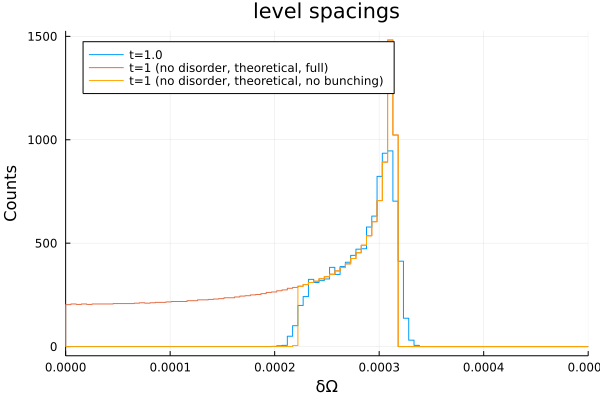

In [225]:
selection = [6];
ponly = stephist(transpose(trange[selection]), transpose(δΩ[selection, :]),
				bins=range(start=0, stop=5e-4, length=100), normalize=false,
				label=string.("t=", transpose(trange[selection])),
				xlabel="δΩ", ylabel="Counts", legend=:topright);

t = 1;
k = range(1, stop=N+1);
Ωth = ω0.+2t.*cos.(π*k/(N+1));
δΩth = - Ωth[2:end] + Ωth[1:end-1];
stephist!(ponly, δΩth, 
				bins=range(start=0, stop=5e-4, length=100), normalize=false,
				label="t=$t (no disorder, theoretical, full)",
				xlabel="δΩ", ylabel="Counts", legend=:topleft);
stephist!(ponly, δΩth[N÷4 : N÷4 + N÷2-1], 
				bins=range(start=0, stop=5e-4, length=100), normalize=false,
				label="t=$t (no disorder, theoretical, no bunching)",
				xlabel="δΩ", ylabel="Counts", legend=:topleft, color=:orange);

title!(ponly, "level spacings for t=$t (only)");
xlims!(ponly, 0, 5e-4);
plot!(ponly, title="level spacings");
plot(ponly)


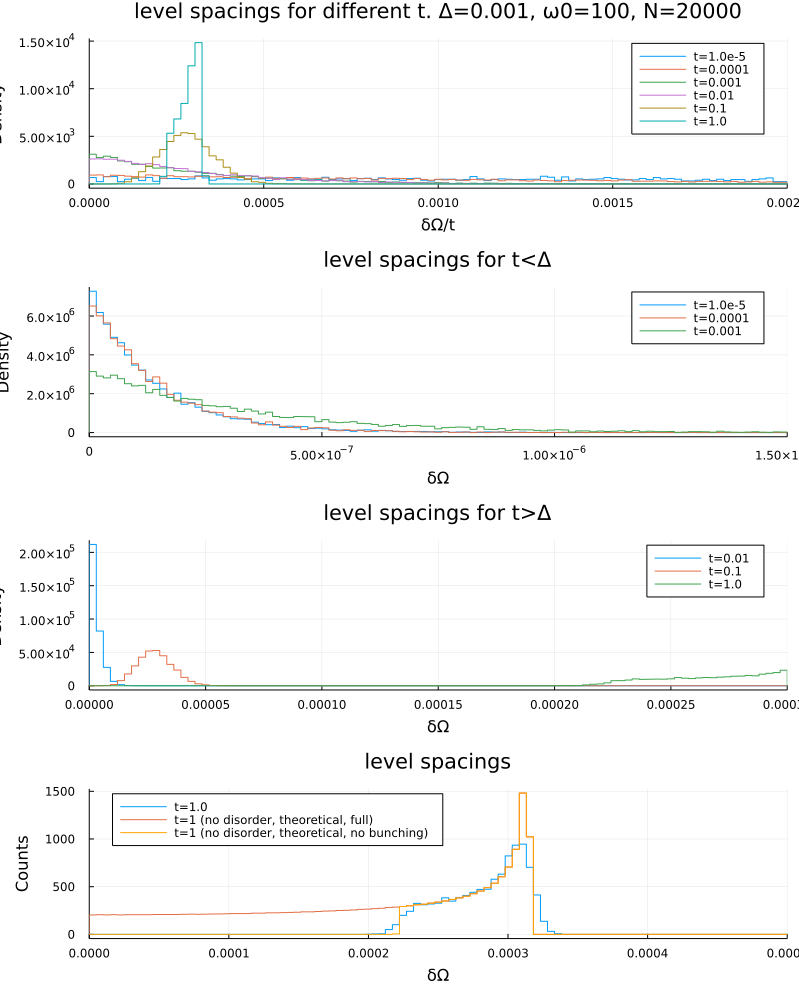

In [226]:
plot(pall, psmall, pbig, ponly, layout=(4, 1), size=(800, 1000))


In [227]:
savefig("histograms_varying_t_nobunching.png")
savefig("histograms_varying_t_nobunching.pdf")

## Anderson transition pt. 2

In [8]:
N = 10000
ω0 = 100
t = 1.
bounds = [ω0 - t, ω0 + t]
# drange = [0., 0.005, 0.01, 0.03, 0.06, 0.1,  0.3] # [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
drange = reverse([0, 0.1, 0.3])
Ωv = Array{Union{Float64, Missing}}(undef, length(drange), N)
δΩ = Array{Union{Float64, Missing}}(undef, length(drange), N-1)
λ = 0.
me = Array{Float64}(undef, length(drange))
for (i, Δ) in enumerate(drange)
	ωv = ω0 .+ rand(Normal(0, Δ), N)
	ham = SymTridiagonal(ωv, fill(t, N-1))
	Ωv[i, :] = eigvals(ham)
	for (j, om) in enumerate(Ωv[i, :])
		if !(bounds[1] < om < bounds[2])
			# Ωv[i, j] = missing
		end
	end
	δΩ[i, :] = (Ωv[i, 2:end] - Ωv[i, 1:end-1])
	me[i] = mean(δΩ[i, :])
end

In [5]:
me

7-element Vector{Float64}:
 0.0004000399842631615
 0.00040027889206531377
 0.00040087122394850814
 0.0004035257555607347
 0.00040885984652771703
 0.00041953977808719653
 0.0004920281277212451

In [15]:
stephist(transpose(Ωv), normalize=true, bins=range(97, 103, length=100), title="energy levels",
		label=string.("Δ=", transpose(drange)),
		xlabel="Ω", ylabel="Density", legend=:topright)
plot!(bounds, seriestype=:vline, label="energy window", linestyle=:dash)
savefig("../report/res/levels.pdf")

"/home/michele/Nextcloud/shared_desktop/university/EPFL/studying/lab/report/res/levels.pdf"

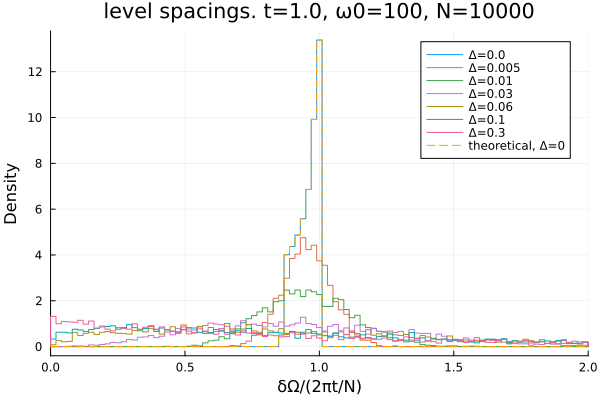

In [14]:
pall = plot();
stephist!(pall, transpose(δΩ./(t*2pi).*N),
		bins=range(start=0, stop=2, length=100),
		normalize=true, label=string.("Δ=", transpose(drange)),
		xlabel="δΩ/(2πt/N)", ylabel="Density", legend=:topright);

δΩth = begin
	k = range(1, stop=N+1);
	Ωth = ω0.+2t.*cos.(π*k/(N+1));
	Ωth2 = filter(x->bounds[1]<x<bounds[2], Ωth);
	-Ωth2[2:end] + Ωth2[1:end-1]
end
stephist!(pall, δΩth./(t*2pi).*N,
		bins=range(start=0, stop=2, length=100),
		normalize=true, label="theoretical, Δ=0", linestyle=:dash, linecolor=:orange);

xlims!(pall, 0, 2);
plot!(pall, title="level spacings. t=$t, ω0=$ω0, N=$N")


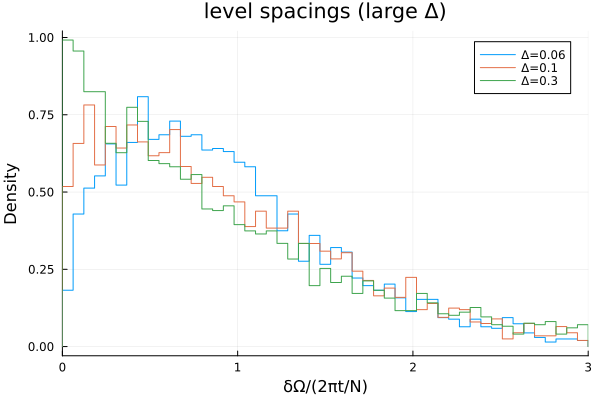

In [18]:
selection = [length(drange)-2, length(drange)-1, length(drange)];
pbig = plot();

stephist!(pbig, transpose(δΩ[selection, :] ./ (t*2pi) .* N),
			bins=range(start=0, stop=3, length=50), normalize=true,
			label=string.("Δ=", transpose(drange[selection])),
			xlabel="δΩ/(2πt/N)", ylabel="Density", legend=:topright);
xlims!(pbig, 0, 3);
plot!(pbig, title="level spacings (large Δ)")

### 2-excitation manifold

In [39]:
N = 1000
ω0 = 100
t = 1.
bounds = [(ω0 - t), (ω0 + t)]
drange = [0., 0.005, 0.01, 1, 2, 5] #[0.05, 0.1, 0.3, 1] #range(0.1, 0.15, 3) #[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
Krange = [0.1, 1, 10] #range(0.0, 0.1, 5)
K = 0
Ω = Array{Array{}}(undef, length(drange), length(Krange))
Ωp = Array{Array{}}(undef, length(drange), length(Krange))
δΩ = Array{Array{}}(undef, length(drange), length(Krange))
δΩp = Array{Array{}}(undef, length(drange), length(Krange))
for (i, Δ) in enumerate(drange), (j, K) in enumerate(Krange)
	ωv = ω0 .+ rand(Normal(0, Δ), N)
	ham = SymTridiagonal(ωv.+K, fill(t, N-1))
	hΩ1, hΩ, hΩp = begin
		println("Δ=$Δ, K=$K")
		# window(x) = bounds[1] <= x - K <= bounds[2]
		function a(b)
			println(b)
		end
		Ω2 = []
		ΔΩ2 = []
		idx = 1
		T = eigen(ham)
		Vdag = T.vectors';
		for i = 1:length(T.values), j = i:length(T.values)
			if bounds[1] <= T.values[i]-K <= bounds[2] &&
					bounds[1] <= T.values[j]-K <= bounds[2]
				push!(Ω2, T.values[i] + T.values[j])
				push!(ΔΩ2, 4K * sum(abs2.(Vdag[i] .* Vdag[j])))
			end
			idx += 1
		end
		sort!(Ω2)
		Ω2pert = sort(Ω2 .+ ΔΩ2)
		T.values, Ω2, Ω2pert
	end
	Ω[i, j] = hΩ
	Ωp[i, j] = hΩp
	δΩ[i, j] = hΩ[2:end] - hΩ[1:end-1]
	δΩp[i, j] = hΩp[2:end] - hΩp[1:end-1]
end

Δ=0.0, K=0.1
Δ=0.0, K=1.0
Δ=0.0, K=10.0
Δ=0.005, K=0.1
Δ=0.005, K=1.0
Δ=0.005, K=10.0
Δ=0.01, K=0.1
Δ=0.01, K=1.0
Δ=0.01, K=10.0
Δ=1.0, K=0.1
Δ=1.0, K=1.0
Δ=1.0, K=10.0
Δ=2.0, K=0.1
Δ=2.0, K=1.0
Δ=2.0, K=10.0
Δ=5.0, K=0.1
Δ=5.0, K=1.0
Δ=5.0, K=10.0


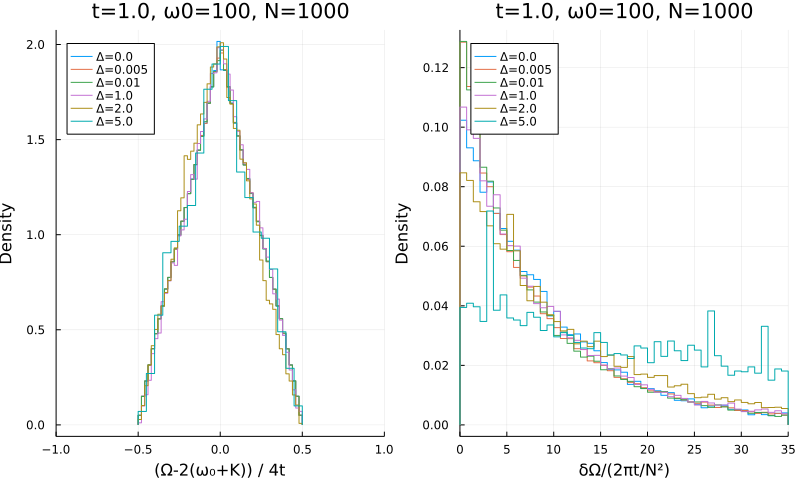

In [29]:
stop = 35
Ωnorm(Ω, K=0) = (Ω.-2ω0 .- 2K) ./ (4t)
δΩnorm(δΩ) = N^2 * δΩ ./ (t*2pi)

pδΩ = plot()
for i in 1:length(drange)
	stephist!(pδΩ, δΩnorm(δΩ[i, 1]),
				normalize=true, label=string.("Δ=", drange[i]),
				bins=range(start=0, stop=stop, length=50),
				xlabel="δΩ/(2πt/N²)", ylabel="Density", legend=:topleft, xlims=(0, stop));
end

pΩ = plot()
for i in 1:length(drange)
	stephist!(pΩ, Ωnorm(Ω[i, 1], Krange[1]),
				normalize=true, label=string.("Δ=", drange[i]), xlims=(-1, 1),
				xlabel="(Ω-2(ω₀+K)) / 4t", ylabel="Density", legend=:topleft);
end
# plot!(pΩ, Ωnorm(bounds), seriestype=:vline, label="energy window", linestyle=:dash)
pall = plot(pΩ, pδΩ, title="t=$t, ω0=$ω0, N=$N", size=(800, 500), bottom_margin=6Plots.mm)

In [40]:
savefig(pall, "../out/spacings_noedges.pdf")

In [53]:
idx = 5
stephist(transpose(Ωnorm(Ω[:, idx, :], Krange)),
				normalize=true, label=string.("K=", transpose(Krange)),
				xlabel="(Ω-(ω₀+K)) / 4t", ylabel="Density",
				bins=range(start=-3, stop=3, length=200),
				legend=:topright, title="t=$t, ω0=$ω0, N=$N, Δ=$(drange[idx])")
savefig("../report/res/levels_K_D2.pdf")

"/home/michele/Nextcloud/shared_desktop/university/EPFL/studying/lab/report/res/levels_K_D2.pdf"

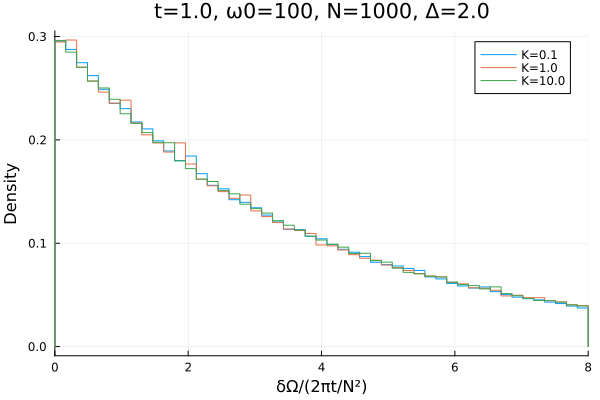

In [44]:
idx = 5

stephist(transpose(δΩnorm(δΩ[:, idx, :])),
				normalize=true, label=string.("K=", transpose(Krange)),
				bins=range(start=0, stop=stop, length=50),
				xlabel="δΩ/(2πt/N²)", ylabel="Density",
				legend=:topright, xlims=(0, stop), title="t=$t, ω0=$ω0, N=$N, Δ=$(drange[idx])")


In [53]:
savefig("../report/levelspacing_K_D2.pdf")

"/home/michele/Nextcloud/shared_desktop/university/EPFL/studying/lab/report/levelspacing_K_D2.pdf"

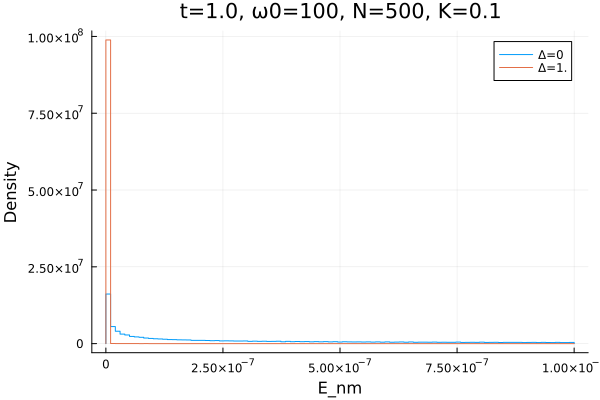

In [163]:
# no disorder
N = 500
K = 0.1
Δ = 0.
ωv = ω0 .+ rand(Normal(0, Δ), N)
ham = SymTridiagonal(ωv.+K, fill(t, N-1))
ΔΩ0 = Array{Float64}(undef, N*(N+1)÷2);
T = eigen(ham)
Vdag = T.vectors';
idx = 1
for i = 1:N, j = i:N
	ΔΩ0[idx] = 4K * sum(abs2.(Vdag[i] .* Vdag[j]))
	idx += 1
end

Δ = 1.
ωv = ω0 .+ rand(Normal(0, Δ), N)
ham = SymTridiagonal(ωv.+K, fill(t, N-1))
ΔΩ1 = Array{Float64}(undef, N*(N+1)÷2);
T = eigen(ham)
Vdag = T.vectors';
idx = 1
for i = 1:N, j = i:N
	ΔΩ1[idx] = 4K * sum(abs2.(Vdag[i] .* Vdag[j]))
	idx += 1
end


stephist((([ΔΩ0 ΔΩ1])),
		normalize=true, label=["Δ=0" "Δ=1."],
		xlabel="E_nm", ylabel="Density", legend=:topright,
		title="t=$t, ω0=$ω0, N=$N, K=$K",
		bins=range(0, 1e-6, 100))

## random matrix spectrum

In [34]:
N = 1000
prand = plot()
deltas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
spacings = zeros(Float32, length(deltas), N-1)
Δ = 0
for (i, Δ) in enumerate(deltas)
	rmat = Symmetric(randn(Float32, N, N).*Δ + diagm(fill(1.f0, N)))
	vals = eigvals(rmat)
	if !issorted(vals)
		println("not sorted")
	end
	spacings[i, :] = vals[2:end] - vals[1:end-1]
end
stephist(prand, transpose(spacings./deltas), bins=range(start=-1, stop=1, length=100), normalize=true,
			label=string.("Δ = ", transpose(deltas)), xlabel="Ω/Δ", ylabel="Density", legend=:topright)
savefig("randsym.png")
savefig("randsym.pdf")


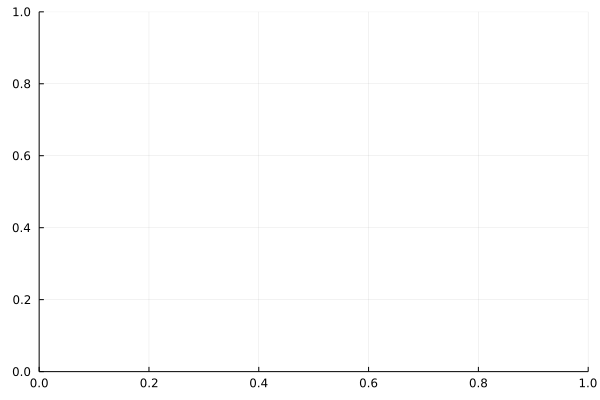

In [32]:
prand

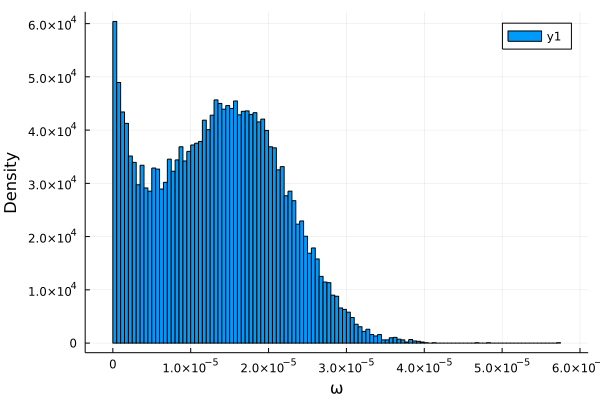

In [7]:
δΩ_gr_hist = histogram(δΩ_gr, nbins=200, normalize=true)
plot(δΩ_gr_hist, label="ωv", xlabel="ω", ylabel="Density", legend=:topright)

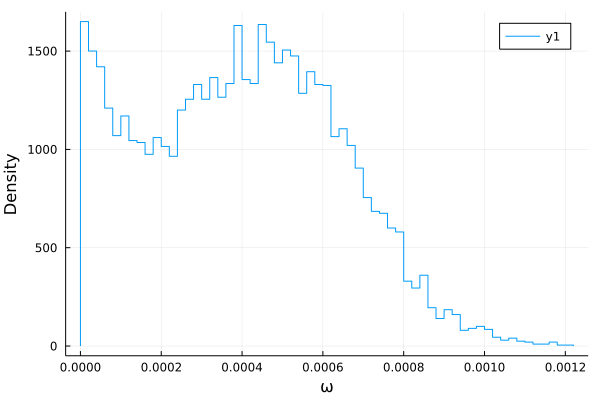

In [33]:
ωv_gr, Ωv_gr = ω_statistic(1, 0.0005, 10000, 0.03)
δΩ_gr = Ωv_gr[2:end] - Ωv_gr[1:end-1]
δΩ_gr_hist = stephist(δΩ_gr / 0.03, nbins=100, normalize=true)
plot(δΩ_gr_hist, label="ωv", xlabel="ω", ylabel="Density", legend=:topright)

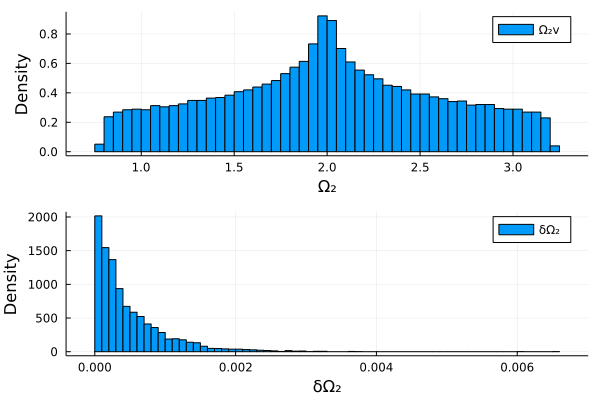

In [142]:
N = 100;
ωv, Ωv = ω_statistic(1, 0.03, N, 0.3);
# for i<j elements in Ωv
Ω₂v = zeros(count_states(N, 2))
idx = 1
for i = 1:N, j = 1:N
	if i < j
		Ω₂v[idx] = Ωv[i] + Ωv[j]
		idx += 1
	end
end
for i = 1:N
	Ω₂v[idx] = 2Ωv[i]
	idx += 1
end
sort!(Ω₂v)
Ω₂_hist = normalize(fit(Histogram, Ω₂v, nbins=100))
p1 = plot(Ω₂_hist, label="Ω₂v", xlabel="Ω₂", ylabel="Density", legend=:topright)
δΩ₂v = Ω₂v[2:end] - Ω₂v[1:end-1]
δΩ₂_hist = normalize(fit(Histogram, δΩ₂v, nbins=100))
p2 = plot(δΩ₂_hist, label="δΩ₂", xlabel="δΩ₂", ylabel="Density", legend=:topright)
p = plot(p1, p2, layout=(2, 1))

## Cross-over in the spacings for nonzero K

In [216]:
N = 1000
ω0 = 10
Δ = 0.1
trange = [1, 0.3, 0.1, 0.05] #[0.05, 0.1, 0.3, 1] #range(0.1, 0.15, 3) #[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
Krange = range(0.0, 1., 5)
K = 0
Ω = Array{Float64}(undef, length(Krange), length(trange), count_states(N, 2))
Ωp = Array{Float64}(undef, length(Krange), length(trange), count_states(N, 2))
δΩ = Array{Float64}(undef, length(Krange), length(trange), count_states(N, 2)-1)
δΩp = Array{Float64}(undef, length(Krange), length(trange), count_states(N, 2)-1)
for (i, t) in enumerate(trange), (j, K) in enumerate(Krange)
	ωv = ω0 .+ rand(Normal(0, Δ), N)
	ham = SymTridiagonal(ωv, fill(t, N-1))
	hΩ, hΩp = spacingstats(ham)
	Ω[j, i, :] = hΩ
	Ωp[j, i, :] = hΩp
	δΩ[j, i, :] = hΩ[2:end] - hΩ[1:end-1]
	δΩp[j, i, :] = hΩp[2:end] - hΩp[1:end-1]
end

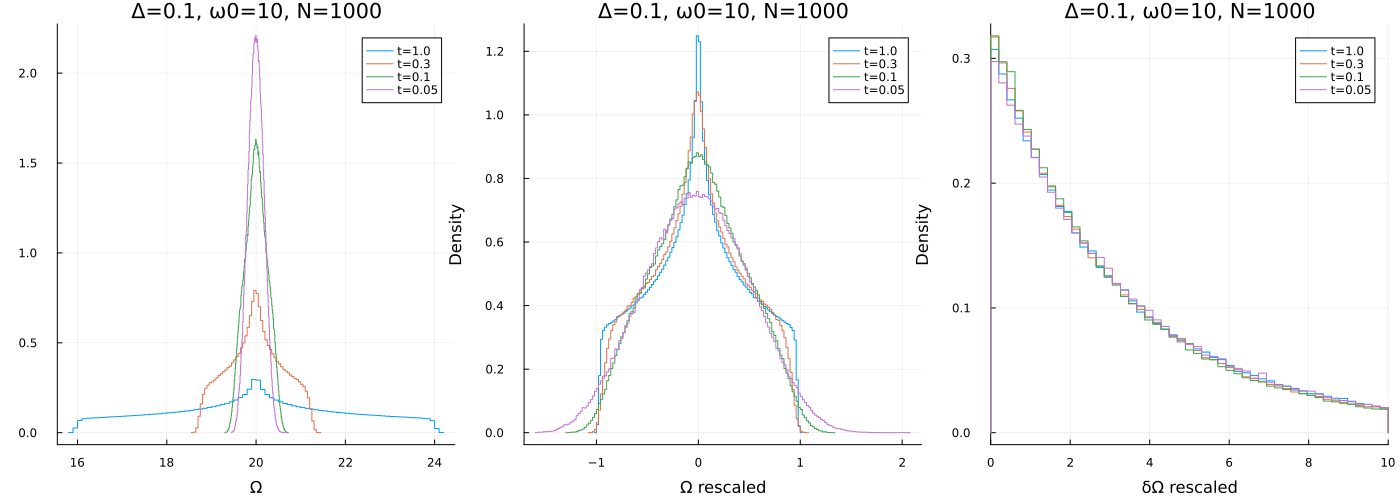

In [218]:
stop = 10
Ωnorm(Ω) = (Ω.-2ω0) ./ (4trange.+Δ*sqrt(2))
δΩnorm(δΩ) = N^2 * δΩ ./ (4trange.+Δ*sqrt(2))

pδΩ = stephist(transpose(δΩnorm(δΩ[1, :, :])),
normalize=true, label=string.("t=", transpose(trange)),
bins=range(start=0, stop=stop, length=50),
xlabel="δΩ rescaled", ylabel="Density", legend=:topright, xlims=(0, stop));

pΩ = stephist(transpose(Ω[1, :, :]),
		normalize=true, label=string.("t=", transpose(trange)),
		xlabel="Ω", ylabel="Density", legend=:topright);
pΩrescaled = stephist(transpose(Ωnorm(Ω[1, :, :])),
		normalize=true, label=string.("t=", transpose(trange)),
		xlabel="Ω rescaled", ylabel="Density", legend=:topright);
pall = plot(pΩ, pΩrescaled, pδΩ, title="Δ=$Δ, ω0=$ω0, N=$N", size=(1400, 500), layout=(1, 3), bottom_margin=6Plots.mm)

In [30]:
savefig("crossover_eigval-spacings.pdf")

"/home/michele/Nextcloud/shared_desktop/university/EPFL/studying/lab/simulation/crossover_eigval-spacings.pdf"

In [259]:
stop = 10
bins = range(start=0, stop=stop, length=200)
pδΩKseries = transpose(δΩ[:, 3, :].*N^2)
pδΩK = stephist(pδΩKseries,
	normalize=false, label=string.("K=", transpose(Krange)),
	bins=bins,
	xlabel="δΩ", ylabel="Counts", legend=:topright, xlims=(0, stop))

pδΩKdetail = stephist(transpose(δΩ[:, 3, :].*N^2),
	normalize=false, label=string.("K=", transpose(Krange)),
	bins=range(start=0, stop=1, length=200),
	xlabel="δΩ", ylabel="Counts", legend=:topright, xlims=(0, 1))

histK0 = fit(Histogram, pδΩKseries[:, 1], bins)
histK1 = fit(Histogram, pδΩKseries[:, 5], bins)
diffhist = Histogram(histK0.edges, histK0.weights .- histK1.weights)
pdiff = plot(diffhist, label="effect of perturbation: K=0 - K=1", xlabel="δΩ", ylabel="Counts", legend=:topright)
plot(pδΩK, pδΩKdetail, pdiff, layout=(3, 1), size=(800, 800), bottom_margin=6Plots.mm)
savefig("crossover_K-spacings.pdf")

"/home/michele/Nextcloud/shared_desktop/university/EPFL/studying/lab/simulation/crossover_K-spacings.pdf"

## histogram for $\Delta \ll t$

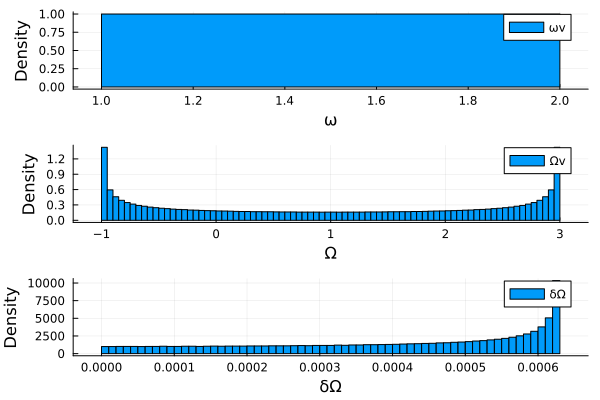

In [7]:
ωv, Ωv = ω_statistic(1, 0.0, 10000, 1.)
ωv_hist = normalize(fit(Histogram, ωv, nbins=100))
p1 = plot(ωv_hist, label="ωv", xlabel="ω", ylabel="Density", legend=:topright)
Ωv_hist = normalize(fit(Histogram, Ωv, nbins=100))
p2 = plot(Ωv_hist, label="Ωv", xlabel="Ω", ylabel="Density", legend=:topright)
δΩ = Ωv[2:end] - Ωv[1:end-1]
δΩ_hist = normalize(fit(Histogram, δΩ, nbins=100))
p3 = plot(δΩ_hist, label="δΩ", xlabel="δΩ", ylabel="Density", legend=:topright)
p = plot(p1, p2, p3, layout=(3, 1))

## histogram for $\Delta = t$

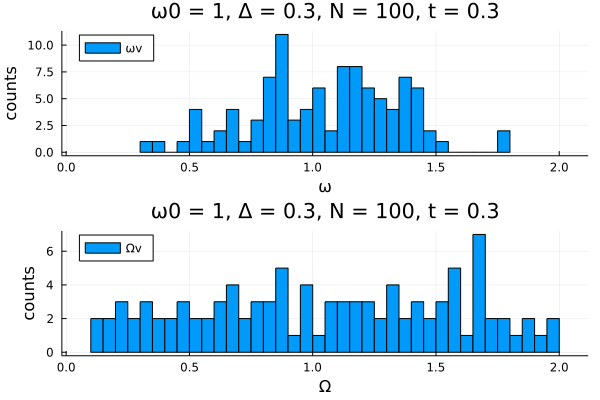

In [4]:
plot_statistic(1, 0.3, 100, 0.3)

## histogram for $\Delta \gg t$

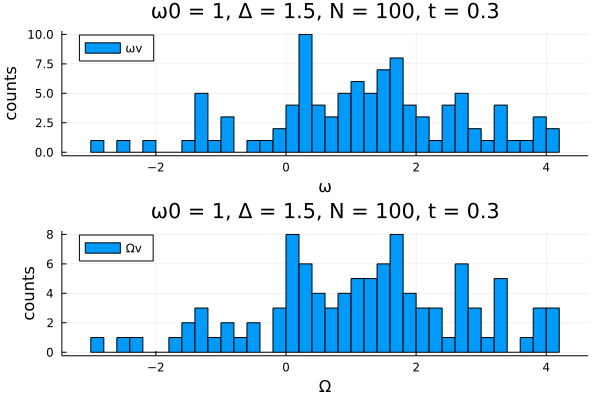

In [5]:
plot_statistic(1, 1.5, 100, 0.3)

## counting states
$$n = \frac{(N+k-1)!}{(N-1)!k!}$$

# statistics 2

In [12]:
# parameters
t = 0.3
K = 0.5
Δ = 0.0
N = 100
ω0 = 1
ωv = ω0 .+ rand(Normal(0, Δ), N);

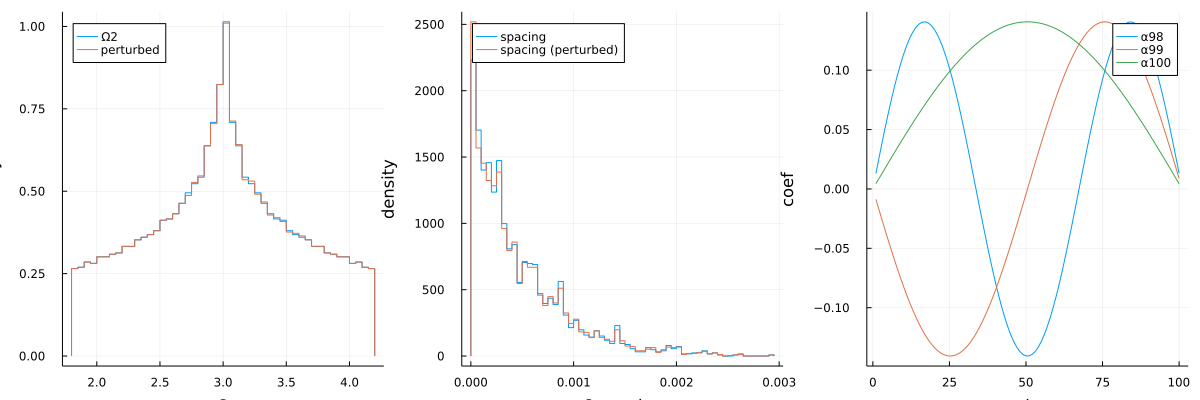

In [15]:

# Hamiltonian matrix in basis a
hmat1 = SymTridiagonal(ωv.+K, fill(t, N-1))
# Calculate eigenvalues Ω2 and perturbed eigenvalues Ω2pert
T = eigen(hmat1)
Vdag = T.vectors';
Ω2 = Array{Float64}(undef, count_states(N, 2));
ΔΩ2 = Array{Float64}(undef, count_states(N, 2));
idx = 1
for i = 1:N, j = i:N
	Ω2[idx] = T.values[i] + T.values[j]
	ΔΩ2[idx] = 4K * sum(abs2.(Vdag[i] .* Vdag[j]))
	idx += 1
end
sort!(Ω2)
Ω2pert = sort(Ω2 .+ ΔΩ2)


# energy levels
Ω2_hist = normalize(fit(Histogram, Ω2, nbins=100))
p = stephist([Ω2 Ω2pert], label=["Ω2" "perturbed"], xlabel=["Ω" "Ω"], ylabel=["density" "density"], legend=:topleft, normalize=:pdf, bins=101)
# level spacing
Ω2spc = Ω2[2:end] - Ω2[1:end-1]
Ω2spc_pert = Ω2pert[2:end] - Ω2pert[1:end-1]
pΩ2spc = stephist([Ω2spc Ω2spc_pert], label=["spacing" "spacing (perturbed)"], xlabel="Ω spacing", ylabel="density", legend=:topleft, normalize=:pdf, bins=101)
# plot Fourier-like coefficients
pcoef = plot(T.vectors[:, 98:end], labels=hcat(["α$i" for i in 98:101]...), xlabel="i", ylabel="coef")
plot(p, pΩ2spc, pcoef, layout=(1, 3), size=(1200, 400))



In [71]:
# parameters
t = 0.005
K = 0.0
Δ = 0.002
N = 200
ω0 = 1
ωv = ω0 .+ rand(Normal(0, Δ), N);

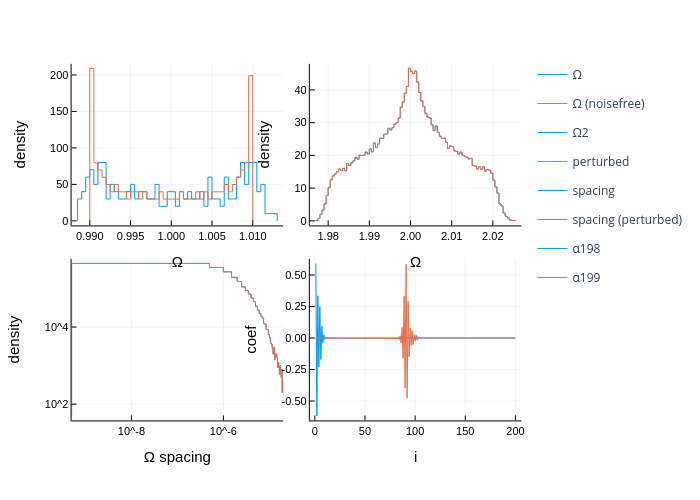

In [75]:

# Hamiltonian matrix in basis a
hmat1 = SymTridiagonal(ωv.+K, fill(t, N-1))
# Calculate eigenvalues Ω2 and perturbed eigenvalues Ω2pert
T = eigen(hmat1)
V = T.vectors
Vdag = T.vectors';
Ω2 = Array{Float64}(undef, count_states(N, 2));
ΔΩ2 = Array{Float64}(undef, count_states(N, 2));
idx = 1
for i = 1:N, j = i:N
	Ω2[idx] = T.values[i] + T.values[j]
	ΔΩ2[idx] = 4K * sum(Vdag[i] .* Vdag[j] .* V[:, i] .* V[:, j])
	idx += 1
end
sort!(Ω2)
Ω2pert = sort(Ω2 .+ ΔΩ2)

# 1 excitation
pΩ = stephist(T.values, label="Ω", xlabel="Ω", ylabel="density", legend=:topleft, normalize=:pdf, bins=51)
begin
	k = range(1, stop=N+1)
	stephist!(pΩ, ω0.+K.+2t.*cos.(π*k/(N+1)), label="Ω (noisefree)", normalize=:pdf, bins=51)
end
# energy levels
Ω2_hist = normalize(fit(Histogram, Ω2, nbins=100))
p = stephist([Ω2 Ω2pert], label=["Ω2" "perturbed"], xlabel=["Ω" "Ω"], ylabel=["density" "density"], legend=:topleft, normalize=:pdf, bins=101)
# level spacing
Ω2spc = Ω2[2:end] - Ω2[1:end-1]
Ω2spc_pert = Ω2pert[2:end] - Ω2pert[1:end-1]
pΩ2spc = stephist([Ω2spc Ω2spc_pert], xlimits=(-Inf, 0.00002), label=["spacing" "spacing (perturbed)"], xlabel="Ω spacing", ylabel="density", legend=:topleft, normalize=:pdf, bins=1201, scale=:log10)
# plot Fourier-like coefficients
pcoef = plot(T.vectors[:, end-2:end], labels=hcat(["α$i" for i in size(Vdag, 1)-2:size(Vdag, 1)+1]...), xlabel="i", ylabel="coef")
plot(pΩ, p, pΩ2spc, pcoef, layout=(2, 2), size=(1200, 400))



In [51]:
savefig("2excitations.pdf")

### Two qubits

In [21]:
# parameters
t = 0.005
K = 0.05
Δ = 0.000
N = 2
ω0 = 1
ωv = ω0 .+ rand(Normal(0, Δ), N);

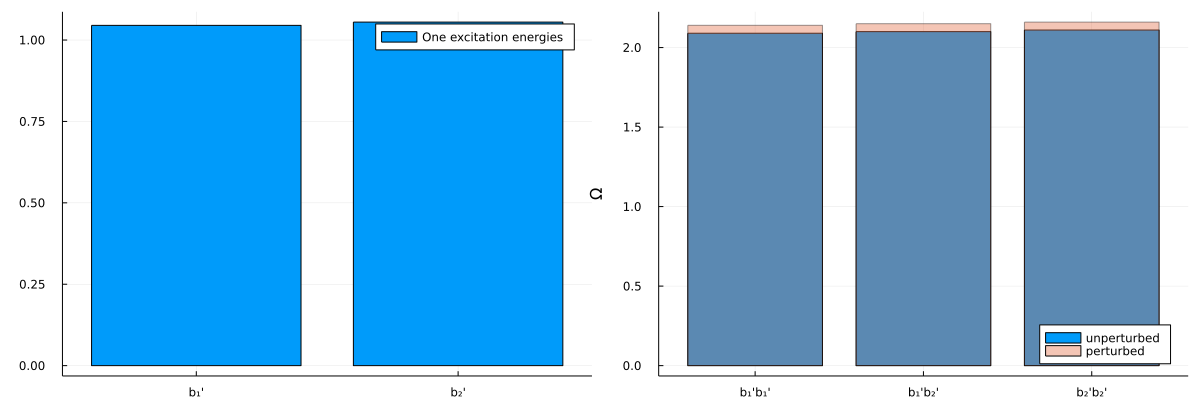

In [22]:

# Hamiltonian matrix in basis a
hmat1 = SymTridiagonal(ωv.+K, fill(t, N-1))
# Calculate eigenvalues Ω2 and perturbed eigenvalues Ω2pert
T = eigen(hmat1)
Vdag = T.vectors';
Ω2 = Array{Float64}(undef, count_states(N, 2));
ΔΩ2 = Array{Float64}(undef, count_states(N, 2));
idx = 1
for i = 1:N, j = i:N
	Ω2[idx] = T.values[i] + T.values[j]
	ΔΩ2[idx] = 4K * sum(abs2.(Vdag[i] .* Vdag[j]))
	idx += 1
end
sort!(Ω2)
Ω2pert = sort(Ω2 .+ ΔΩ2)

# 1 excitation
pΩ = bar(["b₁'", "b₂'"], T.values, label="One excitation energies", ylabel="Ω")
# energy levels
Ω2_hist = normalize(fit(Histogram, Ω2, nbins=100))
p = bar(["b₁'b₁'", "b₁'b₂'", "b₂'b₂'"], Ω2, label="unperturbed", ylabel="Ω")
bar!(p, ["b₁'b₁'", "b₁'b₂'", "b₂'b₂'"], Ω2pert, label="perturbed", alpha=0.4, legend=:bottomright)
# level spacing
Ω2spc = Ω2[2:end] - Ω2[1:end-1]
Ω2spc_pert = Ω2pert[2:end] - Ω2pert[1:end-1]
plot(pΩ, p, layout=(1, 2), size=(1200, 400))



In [10]:
ΔΩ2

3-element Vector{Float64}:
 0.04999999999999998
 0.04999999999999998
 0.04999999999999998

## Full Bogolyubov

In [28]:
# parameters
t = 0.005
K = 0.05
Δ = 0.001
N = 3
ω0 = 1
ωv = ω0 .+ rand(Normal(0, Δ), N);

In [67]:
# Hamiltonian matrix in basis a
Xd = ωv.+K
Xo = fill(t, N-1)
hmat1 = SymTridiagonal(vcat(Xd, -Xd), vcat(Xo, [0], -Xo))
# Calculate eigenvalues Ω2 and perturbed eigenvalues Ω2pert
T = eigen(hmat1;)
ev = T.values
perm1 = sortperm(-ev[1:N])
perm2 = sortperm(ev[N+1:2N])
ev2, ev1 = T.values[1:N][perm1], T.values[N+1:2N][perm2]
Vdag = T.vectors;
V2, V1 = Vdag[1:N, perm1], Vdag[N+1:2N, perm2];

# check that diff is all zeros
if !all(abs.(ev1 + ev2) .< 1e-6)
	println("Error: diff is not all zeros")
else
	println("Success: diff is all zeros")
end

hmat_mine = SymTridiagonal(Xd, Xo)
T_mine = eigen(hmat_mine)
ev_mine = T_mine.values
if !all(abs.(ev_mine - ev1) .< 1e-6)
	println("Error: mine is not all zeros")
else
	println("Success: Bogolyubov transfomation produces the same eigenvalues Ω")
end

Success: diff is all zeros
Success: Bogolyubov transfomation produces the same eigenvalues Ω


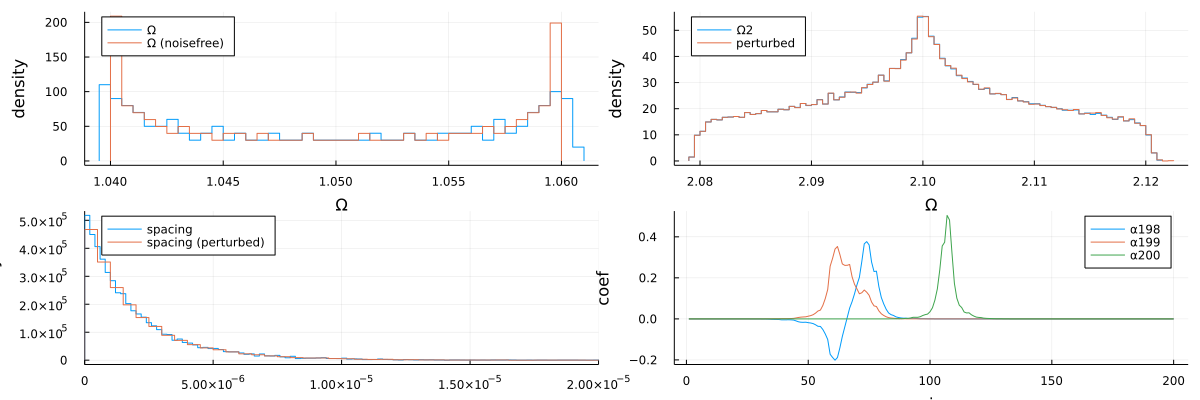

In [ ]:
V = T.vectors
Vdag = T.vectors';
Ω2 = Array{Float64}(undef, count_states(N, 2));
ΔΩ2 = Array{Float64}(undef, count_states(N, 2));
idx = 1
for i = 1:N, j = i:N
	Ω2[idx] = T.values[i] + T.values[j]
	ΔΩ2[idx] = 4K * sum(Vdag[i] .* Vdag[j] .* V[:, i] .* V[:, j])
	idx += 1
end
sort!(Ω2)
Ω2pert = sort(Ω2 .+ ΔΩ2)

# 1 excitation
pΩ = stephist(T.values, label="Ω", xlabel="Ω", ylabel="density", legend=:topleft, normalize=:pdf, bins=51)
begin
	k = range(1, stop=N+1)
	stephist!(pΩ, ω0.+K.+2t.*cos.(π*k/(N+1)), label="Ω (noisefree)", normalize=:pdf, bins=51)
end
# energy levels
Ω2_hist = normalize(fit(Histogram, Ω2, nbins=100))
p = stephist([Ω2 Ω2pert], label=["Ω2" "perturbed"], xlabel=["Ω" "Ω"], ylabel=["density" "density"], legend=:topleft, normalize=:pdf, bins=101)
# level spacing
Ω2spc = Ω2[2:end] - Ω2[1:end-1]
Ω2spc_pert = Ω2pert[2:end] - Ω2pert[1:end-1]
pΩ2spc = stephist([Ω2spc Ω2spc_pert], xlimits=(-Inf, 0.00002), label=["spacing" "spacing (perturbed)"], xlabel="Ω spacing", ylabel="density", legend=:topleft, normalize=:pdf, bins=1201)
# plot Fourier-like coefficients
pcoef = plot(T.vectors[:, end-2:end], labels=hcat(["α$i" for i in size(Vdag, 1)-2:size(Vdag, 1)+1]...), xlabel="i", ylabel="coef")
plot(pΩ, p, pΩ2spc, pcoef, layout=(2, 2), size=(1200, 400))



### next steps
take the perturbation K to be from 0% to 10% of $\omega_0$.

Also try with different randomness, I don't know the amounts though

$\checkmark$ Use the full Bogoliubov transformation. See if it is algebraically equivalent to what I already did $\checkmark$

The efficient method that I used to calculate the 2 excitation perturbation should be correct once the Hamiltonian is diagnoalized correctly